# 2 - Identificación de outliers y reducción de la dimensionalidad

# Montar directorio de Google Drive

In [ ]:
## Solicitar acceso y montar en el sistema tu directorio de Google Drive
# Esto permitirá la persistencia de datos entre distintas sesiones
import os, sys
from google.colab import drive
drive.mount('/content/drive')

# Creamos un directorio para este cuaderno y lo asociamos
drive_path = '/content/drive/MyDrive/Colab Notebooks/iabd-sbd'
nb_path = '/content/iabd-sbd'

if not os.path.exists(drive_path):
    os.makedirs(drive_path)
os.symlink(drive_path, nb_path)
sys.path.insert(0,nb_path)

%cd $nb_path

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/iabd-sbd


# Instalación de spark en Google Colab

In [ ]:
# Spark está escrito en el lenguaje de programación Scala, por lo que requiere
# de una máquina virtual de Java (JVM) para funcionar. Por lo tanto, lo primero
# es instalar java:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
## Instalación de Apache Spark en Google Colab (Ejecutar solo si no se ha realizado nunca)
# Nota: Puede tardar unos minutos (se paciente)
# El siguiente paso es elegir una versión reciente de spark
# En este notebook, se usará spark versión 3.1.2, la cual puede descargarse en:
spark_file = 'spark-3.3.2-bin-hadoop3.tgz'
spark_url = 'https://archive.apache.org/dist/spark/spark-3.3.2/' + spark_file

# A continuación, descargamos la versión elegida de spark:
import os # Libreria de manejo del sistema operativo
os.system("wget -q {spark_url} -P " + nb_path) # Realizamos la descarga
os.system("tar xf " + nb_path + "/" + spark_file) # Descomprimimos el fichero .tgz

# Realizamos la instalación de pyspark utilizando la herramienta pip
!pip install --target=$nb_path -q pyspark
!pip install -q findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 16.9 MB/s eta 0:00:00


In [ ]:
# Damos permisos de ejecución
!chmod -R +x ./pyspark/

# Finalmente, es necesario definir algunas variables de entorno en el sistema
# operativo para poder usar spark correctamente:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = nb_path + "/pyspark"

## 2.1. Identificación de outliers

### Generación de un dataset simulado
Para este primer ejemplo generaremos una muestra de $100$ elementos de una población normal de media $50$ y desviación estandar de $10$. A continuación introduciremos dos outliers en la muestra, uno teniendo un valor muy pequeño y otro muy grande.

In [ ]:
import numpy as np

# Generación de datos
mu, sigma = 50, 10 # Media y desviación típica de la población

# Generamos una muestra de tamaño 100
np.random.seed(10) # Fijamos una semilla (para reproducibilidad)
datos = np.random.normal(mu, sigma, 100)

# Cambiamos los valores de dos datos para convertirlos en outliers (posiciones 50 y 75)
datos[50]=100
datos[75]=1
datos

array([ 63.31586504,  57.15278974,  34.54599708,  49.9161615 ,
        56.21335974,  42.79914439,  52.65511586,  51.08548526,
        50.04291431,  48.25399789,  54.3302619 ,  62.03037374,
        40.34934329,  60.28274078,  52.2863013 ,  54.45137613,
        38.63397788,  51.35136878,  64.84537002,  39.20195114,
        30.22271719,  32.56627704,  52.66070164,  73.84967331,
        61.23691253,  66.72622213,  50.99149216,  63.97996377,
        47.28752012,  56.13204185,  47.32682811,  44.50690986,
        51.32708296,  45.23857985,  63.08473081,  51.95013279,
        54.00209988,  46.62367663,  62.56472264,  42.68030498,
        56.60231551,  46.49128109,  40.6056664 ,  45.10662783,
        41.95408858,  47.87302361,  46.60859754,  53.12169936,
        55.6515267 ,  48.52579742, 100.        ,  52.89094204,
        44.60120929,  57.0816002 ,  58.42224738,  52.03580797,
        73.94703665,  59.17458938,  48.87727529,  46.37819553,
        47.67817744,  44.982711  ,  61.28785153,  43.02

### Determinación de outliers mediante el método basado en bandas
El método utlizado para determinar estas bandas será el **rango intercuartiles**:
\begin{eqnarray}
x_L= Q_1- k(Q_3-Q_1) \\
x_U=Q_3+ k(Q_3-Q_1),
\end{eqnarray}
donde $k=3$.

In [ ]:
Q1 = np.quantile(datos,0.25)
Q3 = np.quantile(datos,0.75)
IQR = Q3 - Q1

k=3
xL = Q1 - k * IQR
xU = Q3 + k * IQR

for i in range(len(datos)):
        if datos[i] < xL or datos[i] > xU:
          print("El dato[{pos}] = {val} es un outlier".format(pos=i, val=datos[i]))

El dato[50] = 100.0 es un outlier
El dato[75] = 1.0 es un outlier


### Repetir el método anterior utilizando un dataset real

Veamos ahora si existen outliers sobre un dataset real. Para ello utilizaremos el Dataset *Wholesale customers Data Set*.

Los datos han sido tomados del https://archive.ics.uci.edu/ml/datasets/wholesale+customers, *Center for  Machine Learning and Intelligent Systems*, University of California. Esta base de datos representa las ventas anuales de un  distribuidor mayorista a sus $440$ clientes minoristas. El objetivo que se persigue es descubrir los patrones de clientes existentes, con el objetivo de poder orientar adecuadamente las estrategias de marketing a realizar. El objetivo es obtener perfiles de consumos, más allá de la tipología de establecimiento o su localización geográfica.

Esta base de datos tiene $N=440$ registros  (clientes) y un total de $Q=8$ atributos (columnas), definidos por:
*   A: Tipo cliente (1, Distribuidor minorista, 2 Hotel,cafeterías,...)
*   B: Región (1, zona Lisboa, 2 zona Oporto, 3 Otros)
* C: Gasto anual en productos frescos.
* D: Gasto anual en productos lácteos.
* E: Gasto anual en productos de ultramarinos.
* F: Gasto anual en productos congelados.
* G: Gasto anual en detergentes y productos de papelería.
* H: Gasto anual en productos delicatessen.

In [ ]:
## Descarga del fichero de datos Wholesale customers Data.csv
# El fichero puede descargarse directamente de la fuente proporcionada, o se
# puede utilizar el siguiente código para descargarlo de google drive:
# URL: https://drive.google.com/file/d/1cFgqfTbvA3ygd-3nam-bX-8qI4JCw9M1
!gdown --id 1cFgqfTbvA3ygd-3nam-bX-8qI4JCw9M1

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1cFgqfTbvA3ygd-3nam-bX-8qI4JCw9M1
To: /content/drive/MyDrive/Colab Notebooks/iabd-sbd/Wholesale customers data (1).csv
100% 15.0k/15.0k [00:00<00:00, 46.9MB/s]


In [ ]:
# Importar pyspark.sql
from pyspark.sql import*

# Importar SparkContext and SparkConf
from pyspark import SparkContext, SparkConf

In [ ]:
# Establecer las propiedades de Spark:
# - URL de conexión
# - Nombre de la aplicación
conf = SparkConf().setMaster("local").setAppName("2-Identificación-outliers-y-reducción-dimensionalidad")

# Iniciar un cluster de Spark (puede tardar unos minutos)
# Comprobar si ya existe este cluster y en el caso contrario crear uno nuevo
sc = SparkContext.getOrCreate(conf=conf)

# Mostramos el cluster creado
sc

<SparkContext master=local appName=2-Identificación-outliers-y-reducción-dimensionalidad>

In [ ]:
! ls -la

total 2874
drwx------  2 root root    4096 May  9 17:55  bin
-rw-------  1 root root 2902908 May 15 14:38  listings.csv
drwx------  4 root root    4096 May  9 17:55  py4j
drwx------  2 root root    4096 May  9 17:55  py4j-0.10.9.7.dist-info
drwx------ 18 root root    4096 May  9 17:55  pyspark
drwx------  2 root root    4096 May  9 17:55  pyspark-3.4.0.dist-info
drwx------  2 root root    4096 May  9 17:55  share
-rw-------  1 root root   15021 May 15 14:40 'Wholesale customers data (1).csv'


In [ ]:
# Inicializar SQLContext a partir del cluster Spark creado anteriormente
sqlContext = SQLContext(sc)

# Creamos un dataframe a partir del archivo CSV descargado anteriormente y
# que contiene el dataset que utilizaremos en esta sesión
df = sqlContext.read.csv('Wholesale customers data (1).csv', header=True, sep=",", inferSchema = "true")

# Eliminamos las columnas channel y region (no aportan información relevante en este ejemplo)
df = df.drop("channel", "region")

# Mostrar el contenido del dataframe
df.show()

/content/iabd-sbd/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+-----+-----+-------+------+----------------+----------+
|Fresh| Milk|Grocery|Frozen|Detergents_Paper|Delicassen|
+-----+-----+-------+------+----------------+----------+
|12669| 9656|   7561|   214|            2674|      1338|
| 7057| 9810|   9568|  1762|            3293|      1776|
| 6353| 8808|   7684|  2405|            3516|      7844|
|13265| 1196|   4221|  6404|             507|      1788|
|22615| 5410|   7198|  3915|            1777|      5185|
| 9413| 8259|   5126|   666|            1795|      1451|
|12126| 3199|   6975|   480|            3140|       545|
| 7579| 4956|   9426|  1669|            3321|      2566|
| 5963| 3648|   6192|   425|            1716|       750|
| 6006|11093|  18881|  1159|            7425|      2098|
| 3366| 5403|  12974|  4400|            5977|      1744|
|13146| 1124|   4523|  1420|             549|       497|
|31714|12319|  11757|   287|            3881|      2931|
|21217| 6208|  14982|  3095|            6707|       602|
|24653| 9465|  12091|   294|   

In [ ]:
cuartiles = {
    c: dict(
        zip(["q1", "q3"], df.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in df.columns
}
display(cuartiles)

{'Fresh': {'q1': 3103.0, 'q3': 16933.0},
 'Milk': {'q1': 1530.0, 'q3': 7184.0},
 'Grocery': {'q1': 2147.0, 'q3': 10646.0},
 'Frozen': {'q1': 737.0, 'q3': 3549.0},
 'Detergents_Paper': {'q1': 256.0, 'q3': 3909.0},
 'Delicassen': {'q1': 406.0, 'q3': 1819.0}}

In [ ]:
for c in cuartiles:
    IQR = cuartiles[c]['q3'] - cuartiles[c]['q1']
    cuartiles[c]['xL'] = cuartiles[c]['q1'] - (IQR * 1.5)
    cuartiles[c]['xU'] = cuartiles[c]['q3'] + (IQR * 1.5)
display(cuartiles)

{'Fresh': {'q1': 3103.0, 'q3': 16933.0, 'xL': -17642.0, 'xU': 37678.0},
 'Milk': {'q1': 1530.0, 'q3': 7184.0, 'xL': -6951.0, 'xU': 15665.0},
 'Grocery': {'q1': 2147.0, 'q3': 10646.0, 'xL': -10601.5, 'xU': 23394.5},
 'Frozen': {'q1': 737.0, 'q3': 3549.0, 'xL': -3481.0, 'xU': 7767.0},
 'Detergents_Paper': {'q1': 256.0, 'q3': 3909.0, 'xL': -5223.5, 'xU': 9388.5},
 'Delicassen': {'q1': 406.0, 'q3': 1819.0, 'xL': -1713.5, 'xU': 3938.5}}

In [ ]:
# Partimos de nuestro dataframe. Al poner * mostrará todas las columnas.
# Generaremos columnas sobre la marcha.
# Cuando la función 'when' sea cierto para los valores de la columna 'c' (Dentro de Q1 - Q3)) --> 0
# Con el '.' podemos ir concatenando y decir que haremos cuando no se cumpla. En este caso asignamos 1.
# Por último damos nombre a las columnas que vamos generando.

import pyspark.sql.functions as f

df.select(
    "*",
    *[
        f.when(
            f.col(c).between(cuartiles[c]['xL'], cuartiles[c]['xU']), 0
        ).otherwise(1).alias(c+"_outlier?")
        for c in df.columns
    ]
).show()

+-----+-----+-------+------+----------------+----------+--------------+-------------+----------------+---------------+-------------------------+-------------------+
|Fresh| Milk|Grocery|Frozen|Detergents_Paper|Delicassen|Fresh_outlier?|Milk_outlier?|Grocery_outlier?|Frozen_outlier?|Detergents_Paper_outlier?|Delicassen_outlier?|
+-----+-----+-------+------+----------------+----------+--------------+-------------+----------------+---------------+-------------------------+-------------------+
|12669| 9656|   7561|   214|            2674|      1338|             0|            0|               0|              0|                        0|                  0|
| 7057| 9810|   9568|  1762|            3293|      1776|             0|            0|               0|              0|                        0|                  0|
| 6353| 8808|   7684|  2405|            3516|      7844|             0|            0|               0|              0|                        0|                  1|
|13265| 11

## 2.2. Redución de la dimensionalidad

Volveremos a trabajar con el dataset anterior. Primero utilizaremos el *VectorAssembler* para generar una nueva columna en el dataframe la cual tendrá un vector del tipo DenseVector conteniendo todas las características del dataset.

In [ ]:
# Utilizamos
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
  inputCols = df.columns,
  outputCol = "features"
)
assembled_df = assembler.transform(df)

# Mostramos la nueva columa "features" para las 10 primeras filas del dataset
assembled_df.select("features").show(10, truncate=False)

+---------------------------------------------+
|features                                     |
+---------------------------------------------+
|[12669.0,9656.0,7561.0,214.0,2674.0,1338.0]  |
|[7057.0,9810.0,9568.0,1762.0,3293.0,1776.0]  |
|[6353.0,8808.0,7684.0,2405.0,3516.0,7844.0]  |
|[13265.0,1196.0,4221.0,6404.0,507.0,1788.0]  |
|[22615.0,5410.0,7198.0,3915.0,1777.0,5185.0] |
|[9413.0,8259.0,5126.0,666.0,1795.0,1451.0]   |
|[12126.0,3199.0,6975.0,480.0,3140.0,545.0]   |
|[7579.0,4956.0,9426.0,1669.0,3321.0,2566.0]  |
|[5963.0,3648.0,6192.0,425.0,1716.0,750.0]    |
|[6006.0,11093.0,18881.0,1159.0,7425.0,2098.0]|
+---------------------------------------------+
only showing top 10 rows



Ahora importamos la función PCA del paquete MLlib de Spark y aplicamos un PCA para reducir la dimensionalidad de los datos a dos dimensiones ($k=2$). Entre otras cosas para que sea más sencillo visualizarlo.

In [ ]:
from pyspark.ml.feature import PCA

# Reducimos la dimensionalidad de los datos (a dos dimensiones)
# Estructura muy típica.
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(assembled_df)
assembled_df = pca_model.transform(assembled_df)

# Mostramos la nueva columna de DenseVectors ahora con solo dos dimensiones
assembled_df.select("pca_features").show(10, truncate=False)

+----------------------------------------+
|pca_features                            |
+----------------------------------------+
|[-14112.072868235575,-10409.72068095512]|
|[-9035.245766804817,-12866.653099720976]|
|[-8620.052039365291,-11402.96376687947] |
|[-14452.397183056773,-2544.395594249181]|
|[-24120.04947733022,-6664.475775700886] |
|[-10696.08915346303,-7864.330863747109] |
|[-12746.499853965024,-6811.199325213239]|
|[-8987.467079196213,-10253.698562918678]|
|[-6749.955348988448,-6618.292434904568] |
|[-8638.416392104866,-22304.76079576945] |
+----------------------------------------+
only showing top 10 rows



In [ ]:
# Podemos visualizar la cantidad de varianza por cada componente principal
# De esta forma, para cada una de las variables con las que nos hemos quedado podemos ver cómo de bien explica el modelo.
# Si hubieramos usado una tercera (k=3), tendriamos un nuevo valor en el vector, de manera que la suma cada vez estaría mas cerca de 100.
# El aLgoritmo se encarga de quedarse primero con las componentes que mejor explican el modelo.
pca_model.explainedVariance

DenseVector([0.4596, 0.4052])

Por último, podemos visualizar utilizando matplotlib el nuevo dataset obtenido al calcular las dos compenentes principales. Para ello, lo primero será obtener este nuevo dataframe de Spark y cargarlo en memoria mediante la función *collect*. Se debe tener cuidado, pues estaremos pasando de un dataframe distribuido en el cluster a uno cargado en la memoria principal de la máquina donde ejecute el programa principal, por lo que si este conjunto de datos es muy grande **nos podríamos quedar sin memoria**. Por último, utilizamos la función scater para visualizar los datos.

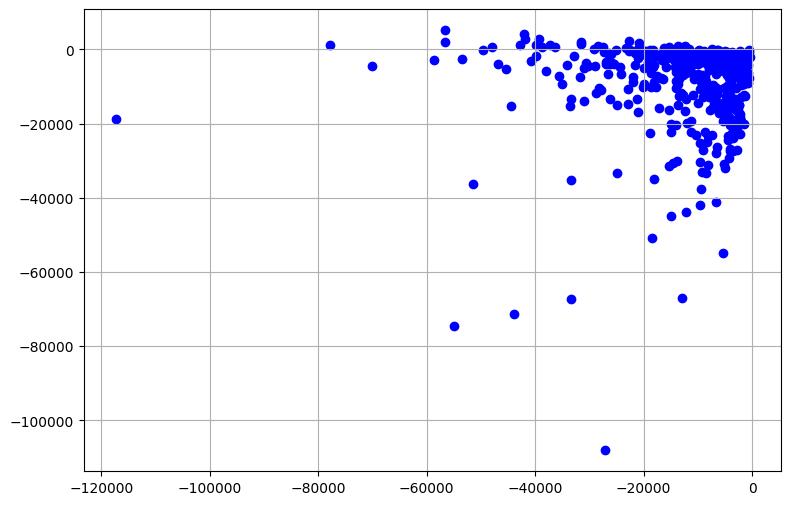

In [ ]:
# Obtenemos de Spark los datos del PCA (cuidado con no desbordar la memoria)
collected_data = assembled_df.select("pca_features").collect()

# Ahora podemos visualizar el dataset utilizando las dos dimensiones obtenidas en el PCA
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6))
for i in range(df.count()):
    plt.scatter(collected_data[i][0][0], collected_data[i][0][1], color="b")
plt.grid()
plt.show()